<a href="https://colab.research.google.com/github/wallisonferreira/machine-learning-pavic/blob/main/pavic_10_pytorch_CV_Custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalhando com datasets customizados

## 0 Importar bibliotecas

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1 Aquisição de dados

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mafaldasalomao/pavic_treinamento_ml/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)


In [4]:
import os

def walk_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"{len(dirnames)} pastas e {len(filenames)} imagens em [{dirpath}].")

In [5]:
walk_dir(image_path)

2 pastas e 0 imagens em [data/pizza_steak_sushi].
3 pastas e 0 imagens em [data/pizza_steak_sushi/test].
0 pastas e 31 imagens em [data/pizza_steak_sushi/test/sushi].
0 pastas e 25 imagens em [data/pizza_steak_sushi/test/pizza].
0 pastas e 19 imagens em [data/pizza_steak_sushi/test/steak].
3 pastas e 0 imagens em [data/pizza_steak_sushi/train].
0 pastas e 72 imagens em [data/pizza_steak_sushi/train/sushi].
0 pastas e 78 imagens em [data/pizza_steak_sushi/train/pizza].
0 pastas e 75 imagens em [data/pizza_steak_sushi/train/steak].


In [6]:
train_dir = image_path / "train" # data/pizza_steak_sushi/train
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Path:  data/pizza_steak_sushi/train/steak/2707522.jpg
Class:  steak
Height:  512
Width:  512


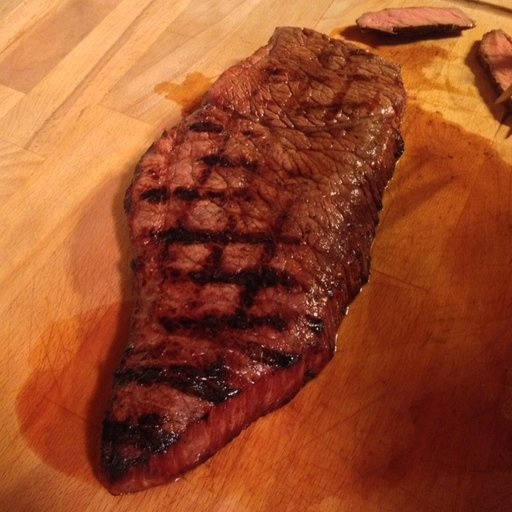

In [7]:
# Visualizar uma imagem

import random
from PIL import Image

#1 ler todos 'caminhos' das imagens
image_path_list = list(image_path.glob("*/*/*.jpg"))

#2 selecionar imagem random
random_image_path = random.choice(image_path_list)

#3 selecionar classe
image_class = random_image_path.parent.stem

#4 ler img
img = Image.open(random_image_path)

print("Path: ", random_image_path)
print("Class: ", image_class)
print("Height: ", img.height)
print("Width: ", img.width)
img

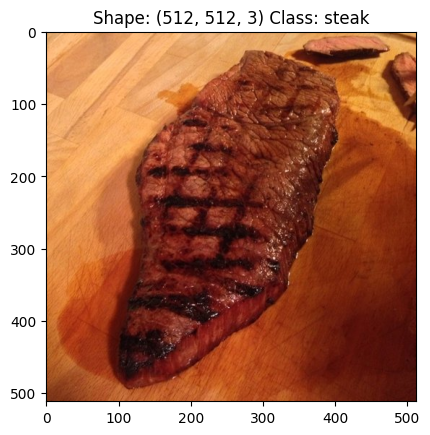

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.imshow(img_array);
plt.title(f"Shape: {img_array.shape} Class: {image_class}");

## 2 Load to Tensors

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3):

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size:{f.size}")
      ax[0].axis("off")
      #[C, H, W]-[3, 64, 64]-[0, 1, 2]-[64, 64, 3]-[H, W , C]
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



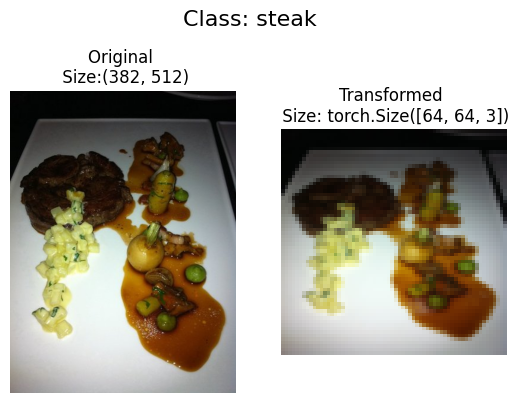

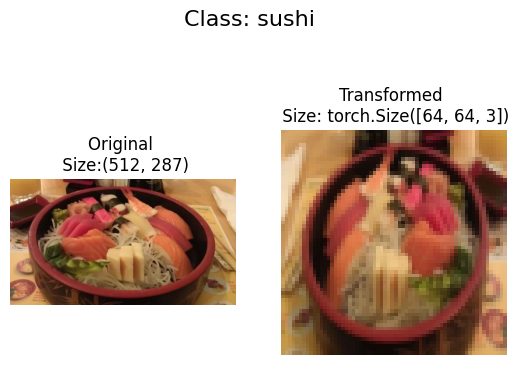

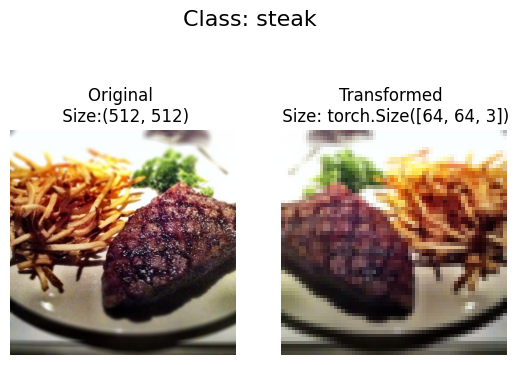

In [12]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Opção 1: Carregar os dados com Image Folder

In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [14]:
#get class
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]

img.shape, img.dtype, label, type(label)

(torch.Size([3, 64, 64]), torch.float32, 0, int)

## 3 Carregar para o Dataloader

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                               batch_size=1,
                               num_workers=1,
                               shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

In [19]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([1, 3, 64, 64])

## Opção 2: Carregar os dados com Custom Dataset

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
#função para retornar lista de classes e dicionario de classes
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Classes nao encontradas na pasta {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [22]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [23]:
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir:str, transform=None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  #Funçãoa para carregar imagens
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  #__len__ -> sobrescrever o metodo
  def __len__(self) -> int:
    return len(self.paths)

  #__getitem__
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img=self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [24]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [25]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [26]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [27]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [28]:
len(train_data_custom) == len(train_data)

True

## 3 Carregar para o DataLoader

In [29]:
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()

In [30]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

## 4 Criar modelo - TinyVGG

In [64]:
%%writefile modular/model.py

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential( # 3, 64,64
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # 10, 32, 32
    )
    self.conv_block_2 = nn.Sequential(# 10, 32, 32
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2) # 10, 16, 16
    )
    self.classiffier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape) #2560->40960->2.621.440
    )
  def forward(self, x):  # 3, 64,64
    x = self.conv_block_1(x)  # 10, 32,32
    x = self.conv_block_2(x)  # 10, 16,16
    x = self.classiffier(x)   # 3
    return x

Writing modular/model.py


In [32]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classiffier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [33]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 5 Treinar o modelo Tiny

In [34]:
device

'cuda'

In [35]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    #1 forward pass
    y_pred = model(X)
    #2 calcular a perda acumulativa
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    #3 zero grad
    optimizer.zero_grad()
    #4 loss backward
    loss.backward()
    #5 optimizer step
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # calcular a média do erro e acurácia
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [36]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  model.eval()

  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      #1forward pass
      test_pred_logits = model(X)
      #2 calcular o erro cumulativo
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y)).sum().item()/len(test_pred_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [37]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  # criar um dicionario vazio para salvar os dados de treinamento
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    #visualizar o comportamento da rede
    print(
        f"Epoch: {epoch + 1} | "
        f"Train_loss: {train_loss:.4f} | "
        f"Train_acc: {train_acc:.4f} | "
        f"Test_loss: {test_loss:.4f} | "
        f"Test_acc: {test_acc:.4f}"
    )
    #atualizar nosso dicionario com as metricas
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [60]:
NUM_EPOCHS = 300
model_0 = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer

start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_custom,
                        test_dataloader=test_dataloader_custom,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
end_time = timer()
print(f"Tempo de treinamento: {end_time-start_time:.3f} segundos.")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 | Train_loss: 1.1038 | Train_acc: 0.2891 | Test_loss: 1.0974 | Test_acc: 0.3816
Epoch: 2 | Train_loss: 1.0846 | Train_acc: 0.5156 | Test_loss: 1.0878 | Test_acc: 0.4242
Epoch: 3 | Train_loss: 1.0730 | Train_acc: 0.4453 | Test_loss: 1.0658 | Test_acc: 0.3816
Epoch: 4 | Train_loss: 1.0089 | Train_acc: 0.6211 | Test_loss: 1.0651 | Test_acc: 0.4242
Epoch: 5 | Train_loss: 0.8974 | Train_acc: 0.5938 | Test_loss: 1.0329 | Test_acc: 0.3807
Epoch: 6 | Train_loss: 0.8567 | Train_acc: 0.5977 | Test_loss: 1.0341 | Test_acc: 0.4725
Epoch: 7 | Train_loss: 0.8366 | Train_acc: 0.5938 | Test_loss: 1.0667 | Test_acc: 0.4337
Epoch: 8 | Train_loss: 0.8349 | Train_acc: 0.6523 | Test_loss: 0.9900 | Test_acc: 0.5152
Epoch: 9 | Train_loss: 0.9183 | Train_acc: 0.5273 | Test_loss: 1.0456 | Test_acc: 0.4233
Epoch: 10 | Train_loss: 0.7743 | Train_acc: 0.6094 | Test_loss: 1.0332 | Test_acc: 0.4650
Epoch: 11 | Train_loss: 0.9421 | Train_acc: 0.5156 | Test_loss: 0.9770 | Test_acc: 0.4432
Epoch: 12 | Train_l

In [39]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 5.1 Plot train info

In [40]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))
  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

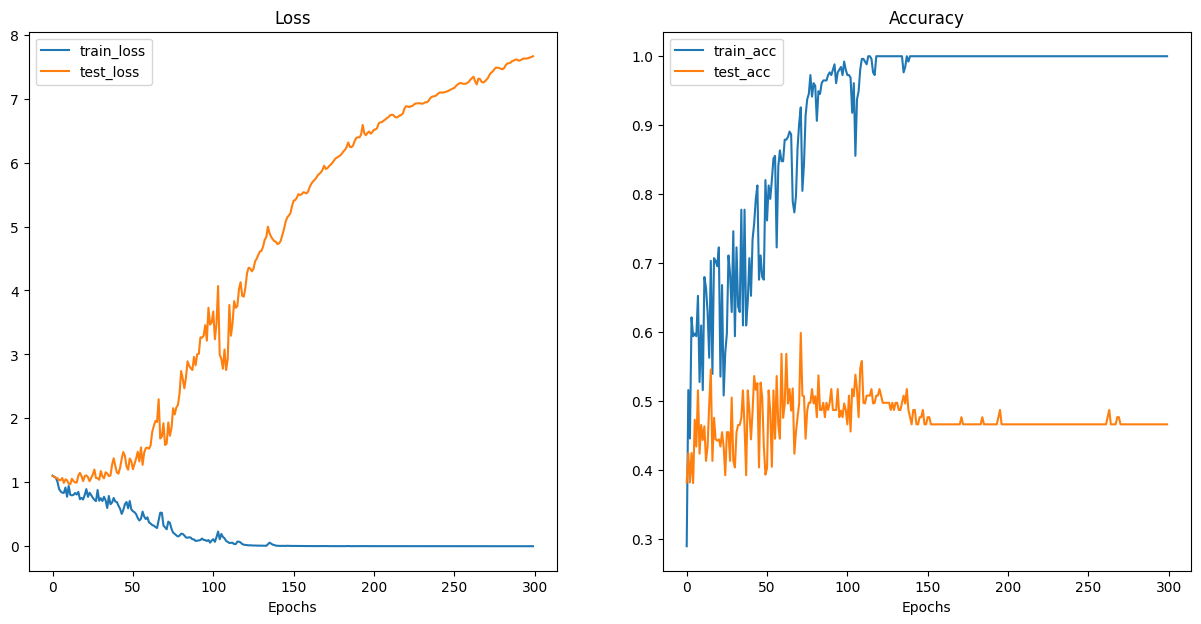

In [61]:
plot_loss_curves(model_0_results)

## 6 Testando o modelo com a imagem da internet

In [46]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str('sushi.jpg'))

# uint8 -> 0 a 255
custom_image_uint8.shape, custom_image_uint8.dtype

(torch.Size([3, 925, 1500]), torch.uint8)

In [47]:
model_0.eval()
with torch.inference_mode():
    model_0(custom_image_uint8.to(device))

RuntimeError: ignored

In [48]:
custom_image = torchvision.io.read_image(str('sushi.jpg')).type(torch.float32)
custom_image = custom_image / 255. # vai ficar entre 0 e 1
custom_image.dtype, custom_image

(torch.float32,
 tensor([[[0.0471, 0.0510, 0.0510,  ..., 0.6824, 0.6784, 0.6784],
          [0.0510, 0.0471, 0.0471,  ..., 0.6784, 0.6745, 0.6863],
          [0.0471, 0.0471, 0.0471,  ..., 0.6784, 0.6784, 0.6745],
          ...,
          [0.4314, 0.4392, 0.4353,  ..., 0.6902, 0.6902, 0.6863],
          [0.4353, 0.4353, 0.4314,  ..., 0.6902, 0.6902, 0.6902],
          [0.4431, 0.4392, 0.4314,  ..., 0.6941, 0.6941, 0.6980]],
 
         [[0.0118, 0.0157, 0.0157,  ..., 0.5843, 0.5882, 0.5882],
          [0.0157, 0.0118, 0.0118,  ..., 0.5882, 0.5843, 0.5961],
          [0.0235, 0.0235, 0.0235,  ..., 0.5882, 0.5882, 0.5961],
          ...,
          [0.2980, 0.3059, 0.3020,  ..., 0.5686, 0.5686, 0.5647],
          [0.2980, 0.3020, 0.2980,  ..., 0.5686, 0.5647, 0.5686],
          [0.2980, 0.2980, 0.2980,  ..., 0.5647, 0.5647, 0.5686]],
 
         [[0.0157, 0.0196, 0.0196,  ..., 0.5569, 0.5569, 0.5569],
          [0.0196, 0.0157, 0.0157,  ..., 0.5569, 0.5529, 0.5647],
          [0.0314, 0.031

(-0.5, 1499.5, 924.5, -0.5)

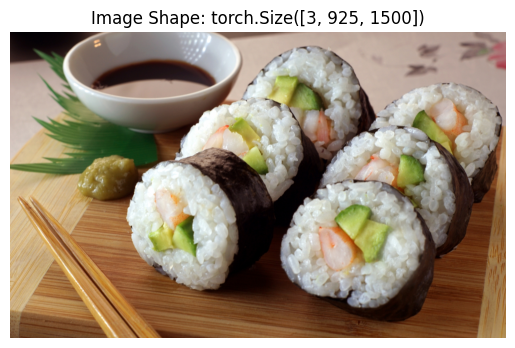

In [49]:
plt.imshow(custom_image.permute(1, 2, 0)) # to turn into wisth, height, channel
plt.title(f"Image Shape: {custom_image.shape}")
plt.axis(False)

In [50]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

(-0.5, 63.5, 63.5, -0.5)

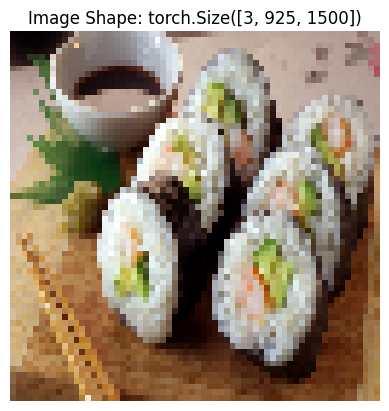

In [51]:
plt.imshow(custom_image_transformed.permute(1, 2, 0)) # to turn into wisth, height, channel
plt.title(f"Image Shape: {custom_image.shape}")
plt.axis(False)

In [52]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred = model_0(custom_image_transformed)

RuntimeError: ignored

### Oras, nosso modelo está na CPU! portanto, é necessário colocar a nova imagem também na CPU.

In [53]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred = model_0(custom_image_transformed.to(device))

RuntimeError: ignored

### Precisamos também colocar a imagem dentro de um wrapper, adicionando uma dimensão a mais, na forma

```
[3, 64, 64] -> [[3, 64, 64]]
```

In [54]:
model_0.eval()
with torch.inference_mode():
    # vai criar uma dimensão a mais na dimensão 0 [] -> [[]]
    custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
    print(f"Novo Shape: {custom_image_transformed.shape}")
    custom_image_pred = model_0(custom_image_transformed.to(device))

Novo Shape: torch.Size([1, 3, 64, 64])


In [55]:
custom_image_pred

tensor([[-1.7498, -2.4418, -1.2005]], device='cuda:0')

In [57]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.

    if transform:
        target_image = transform(target_image)
    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label]} | Probs: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Probs: {target_image_pred_probs.max().cpu():.3f}"

    plt.title(title)
    plt.axis(False)

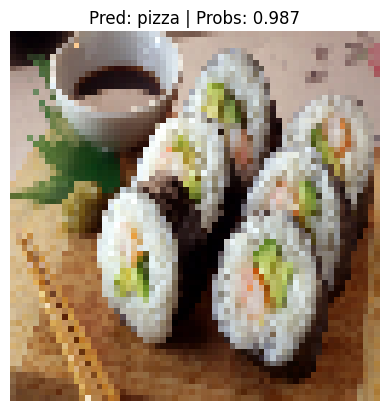

In [62]:
pred_and_plot_image(model=model_0,
                    image_path=str("sushi.jpg"),
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)